In [2]:
library(ggtree)
library(ape)
library(compositions)
library(cowplot)
library(ggplot2)
library(reshape2)
library(lme4)
library(lmerTest)
library(gridExtra)
library(stringr)
 theme_set(theme_cowplot())

ggtree v1.14.6  For help: https://guangchuangyu.github.io/software/ggtree

If you use ggtree in published research, please cite the most appropriate paper(s):

- Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution 2017, 8(1):28-36, doi:10.1111/2041-210X.12628

- Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, accepted. doi: 10.1093/molbev/msy194


Attaching package: ‘ape’


The following object is masked from ‘package:ggtree’:

    rotate


Loading required package: tensorA


Attaching package: ‘tensorA’


The following object is masked from ‘package:base’:

    norm


Loading required package: robustbase

Loading required package: bayesm

Welcome to compositions, a package for compo

In [83]:
#Taken off the internet, used as a buffer in the plot grids
blankPlot <- ggplot()+geom_blank(aes(1,1))+
  theme(
    plot.background = element_blank(), 
   panel.grid.major = element_blank(),
   panel.grid.minor = element_blank(), 
   panel.border = element_blank(),
   panel.background = element_blank(),
   axis.title.x = element_blank(),
   axis.title.y = element_blank(),
   axis.text.x = element_blank(), 
   axis.text.y = element_blank(),
   axis.ticks = element_blank(),
   axis.line = element_blank()
     )

cut_taxonomy_string <- function(x, n) {
    y<-str_split(str_trim(str_flatten(str_split_fixed(str_replace_all(x,"[kpcofgs]__", ""), ";", n=7))), " ")[[1]]
    if (n >= length(y)) {
        n = length(y)
    }
    if (n==7) {
        str_flatten(y[c(n-1, n)], collapse = " ")
    } else {
        y[n]
    }
}

plot_sig_time_series <- function(asv) {
#    sig_sites <- c()
#    for (site in c("SubG", "SupG", "Sal", "T")) {
#        if ((!is.na(taxonomy[asv,paste(site,"_GLM_p_adj",sep="")])) & (taxonomy[asv,paste(site,"_GLM_p_adj",sep="")] <= 0.05)) {
#            sig_sites <- c(sig_sites, site)
#        }
#    }
    sig_sites <- c("SubG", "SupG", "Sal")
    plot_subset <- asv_tab.clr.m %>% subset(asv_id == asv) %>% subset(type %in% sig_sites)
    p <- ggplot(plot_subset,
                 aes(x=time,y=clr_rel_abund,group=type,shape=type,col=phase)) +
                 scale_shape_manual(drop=FALSE, values=c(0,1,5,6)) +
                 stat_summary(fun=mean, geom="line", aes(group=interaction(1,type)))  + 
                 stat_summary(fun=mean, geom="point", size=4, alpha=0.7) +
                 stat_summary(fun.data = mean_se, geom = "errorbar", width=0.1) +
                 scale_colour_brewer(palette = "Dark2") +
                 ggtitle(paste(asv, cut_taxonomy_string(taxonomy[asv,"Taxon"],7), sep="\n")) + 
                 xlab("Time (days)") + ylab("CLR Transformed Abundance") +
                 theme(legend.position="none", 
                       axis.title.y=element_text(size=10),
                       axis.title.x=element_text(size=10),
                       plot.title=element_text(size=10))
    p
}

plot_aggregated_time_series <- function(asvs) {
    plot_subset <- asv_tab.clr.m %>% subset(asv_id %in% asvs)
    agg.plot_subset <- aggregate(list(clr_rel_abund=plot_subset$clr_rel_abund), by=list(sample_id=plot_subset$sample_id, phase=plot_subset$phase, time=plot_subset$time, type=plot_subset$type, subject=plot_subset$subject), FUN=sum)
    p <- ggplot(agg.plot_subset,
                 aes(x=time,y=clr_rel_abund,group=type,shape=type,col=phase)) +
                 scale_shape_manual(drop=FALSE, values=c(0,1,5,6)) +
                 stat_summary(fun.y=mean, geom="line", aes(group=interaction(1,type)))  + 
                 stat_summary(fun.y=mean, geom="point", size=4, alpha=0.7) +
                 stat_summary(fun.data = mean_se, geom = "errorbar", width=0.1) +
                 scale_colour_brewer(palette = "Dark2") +
                 ggtitle("") + 
                 xlab("Time (days)") + ylab("CLR Transformed Abundance") +
                 theme(legend.position="none", 
                       axis.title.y=element_text(size=10),
                       axis.title.x=element_text(size=10),
                       plot.title=element_text(size=10))
    
    p
}

plot_taxon_tree <- function(taxon_query, 
                            layout='circular', 
                            hilight_width=0.05, 
                            heatmap_offset=0.15, 
                            ts_scale_factor=1,
                            exclude_taxon=NULL) {
    targets <- grepl(taxon_query, taxonomy$Taxon)
    taxon_ids <- rownames(taxonomy[targets,])
    if (!is.null(exclude_taxon)) {
        exc <- grepl(exclude_taxon, taxonomy[taxon_ids, 'Taxon'])
        taxon_ids <- taxon_ids[!exc]
    }
    asv_subtree <- keep.tip(asv_tree, taxon_ids)

    tree_taxon_ids <- asv_subtree$tip
    tip_labels <- unlist(
                      lapply(as.character(
                             taxonomy[tree_taxon_ids, 'Taxon']
                             ), 
                            function(x) cut_taxonomy_string(x, 7)
                            )
                         )
    tip_labels <- data.frame(taxa=tree_taxon_ids, 
                             classification=tip_labels,
                             asv_id=tree_taxon_ids,
                             subg_p_val=taxonomy[tree_taxon_ids, "SubG_GLM_p"],
                             subg_slope=taxonomy[tree_taxon_ids, "SubG_GLM_time_slope"],
                             supg_p_val=taxonomy[tree_taxon_ids, "SupG_GLM_p"],
                             supg_slope=taxonomy[tree_taxon_ids, "SupG_GLM_time_slope"],
                             sal_p_val=taxonomy[tree_taxon_ids, "Sal_GLM_p"],
                             sal_slope=taxonomy[tree_taxon_ids, "Sal_GLM_time_slope"],
                             T_p_val=taxonomy[tree_taxon_ids, "T_GLM_p"],
                             T_slope=taxonomy[tree_taxon_ids, "T_GLM_time_slope"],
                             subg_p_adj=taxonomy[tree_taxon_ids, "SubG_GLM_p_adj"],
                             supg_p_adj=taxonomy[tree_taxon_ids, "SupG_GLM_p_adj"],
                             sal_p_adj=taxonomy[tree_taxon_ids, "Sal_GLM_p_adj"],
                             T_p_adj=taxonomy[tree_taxon_ids, "T_GLM_p_adj"],
                             sig=taxonomy[tree_taxon_ids, "SubG_GLM_p_adj"] <= 0.05 | 
                                 taxonomy[tree_taxon_ids, "SupG_GLM_p_adj"] <= 0.05 |
                                 taxonomy[tree_taxon_ids, "Sal_GLM_p_adj"] <= 0.05 |
                                 taxonomy[tree_taxon_ids, "T_GLM_p_adj"] <= 0.05
                            )
    tip_labels$sig[tip_labels$sig == FALSE] <- NA
    i <- 1
    p <- ggtree(asv_subtree, layout=layout)
    if (layout == 'circular' || layout == 'radial' || layout == 'fan') {
        p <- p %<+% tip_labels + geom_tiplab2(aes(label=asv_id, colour=subg_slope)) +
                                 scale_colour_distiller(type = 'div', palette = 'RdBu', direction = -1)
    } else {
        plot_list <- list()
        p <- p %<+% tip_labels + geom_tiplab(aes(label=asv_id), align=TRUE) +
                                 geom_tippoint(aes(shape=sig), colour="red", size=4)
        
        #Create the time-series plots and put them in a list, to plot on the right
        for (asv in na.omit(tip_labels[tip_labels$T_p_val <= 0.05, "taxa"])) {
            sig_node <- p$data$node[p$data$label == asv]
            p <- p + geom_hilight(node=sig_node, extend=hilight_width*4, fill = "#FFFF00")
            plot_list[[i]] <- plot_asv_time_series(asv, "T", taxonomy[asv, 'T_GLM_p'], taxonomy[asv, 'T_GLM_p_adj'])
            i <- i + 1
        }
        for (asv in na.omit(tip_labels[tip_labels$sal_p_val <= 0.05, "taxa"])) {
            sig_node <- p$data$node[p$data$label == asv]
            p <- p + geom_hilight(node=sig_node, extend=hilight_width*3, fill = "#0000FF")
            plot_list[[i]] <- plot_asv_time_series(asv, "Sal", taxonomy[asv, 'Sal_GLM_p'], taxonomy[asv, 'Sal_GLM_p_adj'])
            i <- i + 1
        }
        for (asv in na.omit(tip_labels[tip_labels$supg_p_val <= 0.05, "taxa"])) {
            sig_node <- p$data$node[p$data$label == asv]
            p <- p + geom_hilight(node=sig_node, extend=hilight_width*2, fill = "#00FF00")
            plot_list[[i]] <- plot_asv_time_series(asv, "SupG", taxonomy[asv, 'SupG_GLM_p'], taxonomy[asv, 'SupG_GLM_p_adj'])
            i <- i + 1
        }
        
        for (asv in na.omit(tip_labels[tip_labels$subg_p_val <= 0.05, "taxa"])) {
            sig_node <- p$data$node[p$data$label == asv]
            p <- p + geom_hilight(node=sig_node, extend=hilight_width, fill = "#FF0000")
            plot_list[[i]] <- plot_asv_time_series(asv, "SubG",taxonomy[asv, 'SubG_GLM_p'], taxonomy[asv, 'SubG_GLM_p_adj'])
            i <- i + 1
        }
    }
    #Add a heatmap of effect sizes
    p <- gheatmap(p+theme_tree2(), taxonomy[,c("SubG_GLM_time_slope",
                                               "SupG_GLM_time_slope", 
                                               "Sal_GLM_time_slope", 
                                               "T_GLM_time_slope")], 
                  width=0.1, color='black', 
                  low='black', high='red', 
                  offset=heatmap_offset, colnames_angle=-45) + 
                  scale_fill_distiller(palette="RdYlGn")
    ts <- plot_grid(plotlist=plot_list, ncol=1)
    ts <- plot_grid(plotlist=list(blankPlot, ts, blankPlot), rel_heights=c(1.0, ts_scale_factor, 1.0), ncol=1)
    pl <- plot_grid(p, ts, ncol=2, rel_widths = c(1,0.5))
    pl
}

In [73]:
asv_tree<-read.newick("data/tree_full.nwk")
taxonomy <- read.table("data/taxonomy.tsv", sep="\t", header=1, row.names=1)
taxonomy$Taxa <- taxonomy$asv_id
md <- read.table("data/METADATA.txt", sep="\t", header=1, row.names=1)
rownames(md) <- gsub("-",".",rownames(md))
asv_tab <- read.table("data/asv_table.tsv", sep="\t", comment.char="", skip=1, header=1, row.names=1)
asv_tab.clr <- t(as.data.frame(clr(t(asv_tab))))
rownames(asv_tab.clr) <- rownames(asv_tab)
asv_tab.clr.m <- melt(asv_tab.clr)
colnames(asv_tab.clr.m) <- c("asv_id","sample_id","clr_rel_abund")
asv_tab.clr.m$phase <- md[as.vector(asv_tab.clr.m$sample_id),'phase']
asv_tab.clr.m$time <- md[as.vector(asv_tab.clr.m$sample_id),'timePoint']
levels(asv_tab.clr.m$time)[levels(asv_tab.clr.m$time) == "B"] <- "-7"
asv_tab.clr.m$time <- factor(asv_tab.clr.m$time, levels=c("-7","0","7","14","21","28","35"))
asv_tab.clr.m$type <- md[as.vector(asv_tab.clr.m$sample_id),'sampleType']
asv_tab.clr.m$subject <- md[as.vector(asv_tab.clr.m$sample_id),'subject']

In [4]:
#Fill the Taxonomy data frame with the p values and slopes of a GLM run for each ASV
for (asv in unique(asv_tab.clr.m$asv_id)) {
    for (sample_type in c("SubG", "SupG", "Sal", "T")) {
        #If it's already computed, don't recompute
        if ((paste(sample_type, '_GLM_p', sep="") %in% colnames(taxonomy)) && (!is.na(taxonomy[asv, paste(sample_type, '_GLM_p', sep="")]))) {
            break()
        }
        data_subset <- asv_tab.clr.m[asv_tab.clr.m$asv_id==asv,]
        #We only want to model the induction phase
        data_subset <- subset(data_subset,phase=='induction')
        #We only want to test one sample type at a time
        data_subset <- subset(data_subset,type==sample_type)
        #Encode as numeric for proper regression calculation
        data_subset$time <- as.numeric(as.character(data_subset$time))
        #Turn off warnings for the lm fitting, since a lot of sparse organisms will cause singular matrices
        options(warn=-1)
        fit1 <- tryCatch({
            #****** THIS IS WHERE THE GLM MODEL IS, IF YOU'RE LOOKING FOR IT ******
            fit1 <- lmer(clr_rel_abund~time+(1|subject), data=data_subset)
            }, 
            error = function(e) {fit1 <- NA},
            finally = function(e) fit1,
            silent=TRUE)
        if (!is.na(fit1)) {
            # Note: This is using the lmerModLmerTest anova overload
            # type=2 because we don't believe that there will be meaningful interactions
            p.val <- as.numeric(anova(fit1, type=2)['time',"Pr(>F)"])
            slope_est <- as.numeric(coef(fit1)$subject$time[1])
        } else {
            p.val <- NA
            slope_est <- NA
        }
        options(warn=0)
        taxonomy[asv, paste(sample_type, '_GLM_p', sep="")] <- p.val
        taxonomy[asv, paste(sample_type, '_GLM_time_slope', sep="")] <- slope_est
    }
}
#Get the significant ASVs, after FDR correction
taxonomy[,"SubG_GLM_p_adj"] <- p.adjust(taxonomy[,"SubG_GLM_p"], method = "fdr")
taxonomy[,"SupG_GLM_p_adj"] <- p.adjust(taxonomy[,"SupG_GLM_p"], method = "fdr")
taxonomy[,"Sal_GLM_p_adj"] <- p.adjust(taxonomy[,"Sal_GLM_p"], method = "fdr")
taxonomy[,"T_GLM_p_adj"] <- p.adjust(taxonomy[,"T_GLM_p"], method = "fdr")

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

In [5]:
#If you don't want to run the time-consuming code above, import with this
#write.table(taxonomy, "data/GLM_results.tsv", sep="\t", quote=FALSE)
taxonomy<-read.table("data/GLM_results.tsv", sep="\t")

In [6]:
minitax<-taxonomy[complete.cases(taxonomy$SubG_GLM_p_adj),]
minitax[minitax$SubG_GLM_p_adj<=0.05,]

,Taxon,Confidence,SubG_GLM_p,SubG_GLM_time_slope,SupG_GLM_p,SupG_GLM_time_slope,Sal_GLM_p,Sal_GLM_time_slope,T_GLM_p,T_GLM_time_slope,SubG_GLM_p_adj,SupG_GLM_p_adj,Sal_GLM_p_adj,T_GLM_p_adj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
af15d021e7a019bfca1083d5f89d39fc,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Carnobacteriaceae; g__Granulicatella; s__,0.9159282,1.013245e-04,-0.05179799,1.985268e-01,-0.018505955,0.066361056,0.028821129,0.88566641,0.0015015023,0.0392174365,3.752876e-01,0.4938522,0.9134772
5b0fd4751414404948cd982e2f4b3c13,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Actinomycetaceae; g__Actinomyces; s__,0.9999948,8.655377e-06,-0.06912158,1.491298e-03,-0.054187543,0.271710778,0.007542483,0.22151851,0.0069668795,0.0094372459,1.511804e-01,0.6363455,0.5174420
7ee5ba33b78446d76ae3c85c71b2ab7b,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pasteurellales; f__Pasteurellaceae; g__Haemophilus; s__parainfluenzae,0.9455938,4.558339e-05,-0.06374823,1.080883e-04,-0.061523821,0.085465386,-0.017583809,0.06705839,-0.0055935727,0.0227695915,2.390716e-02,0.4938522,0.4411245
204d401bcaf4b5cf7eb6f5e23dc91d1d,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Veillonellaceae; g__Selenomonas; s__,0.9799151,1.093740e-06,0.08790868,3.085039e-06,0.075897136,0.004131483,0.030780544,0.25320810,-0.0110506094,0.0017888124,2.501967e-03,0.4938522,0.5747154
a5f64d25bfb9184658a6597d76096fb1,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pasteurellales; f__Pasteurellaceae; g__Haemophilus; s__parainfluenzae,0.9685624,4.872734e-05,-0.07250352,5.291483e-04,-0.051151634,0.099856814,-0.016010530,0.28129845,-0.0118201231,0.0227695915,9.404529e-02,0.4938522,0.6262367
fbb1ae43656b5280c270643d716b31a7,k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Fusobacteriaceae; g__Fusobacterium; s__,0.9999885,4.750864e-05,0.05826388,7.939188e-01,-0.003391082,0.013394839,0.020170680,0.78454906,-0.0006195811,0.0227695915,8.394630e-01,0.4938522,0.8312716
bff540f2d9cf8c25ed1bc1a5061f023c,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__,0.9625488,3.594724e-08,-0.11324465,3.769851e-09,-0.092522922,0.015717007,-0.032744507,0.66039078,-0.0035771570,0.0001175834,9.172049e-06,0.4938522,0.7226726
394b7bd8355b485e02d10118bb1d82ca,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus,0.9999993,1.082558e-04,-0.05115887,1.588989e-02,-0.031289164,0.038408920,0.020378392,0.64742681,0.0063236252,0.0392174365,3.521346e-01,0.4938522,0.7214296
e4d9332ac60f495af8c7147d1f9d959d,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Carnobacteriaceae; g__Granulicatella; s__,0.7974547,4.632924e-05,-0.06530718,1.958536e-05,-0.061850827,0.131838242,-0.012006914,0.08297990,-0.0284774580,0.0227695915,7.941863e-03,0.4938522,0.4411245


In [7]:
minitax<-taxonomy[complete.cases(taxonomy$SupG_GLM_p_adj),]
minitax[minitax$SupG_GLM_p_adj<=0.05,]

,Taxon,Confidence,SubG_GLM_p,SubG_GLM_time_slope,SupG_GLM_p,SupG_GLM_time_slope,Sal_GLM_p,Sal_GLM_time_slope,T_GLM_p,T_GLM_time_slope,SubG_GLM_p_adj,SupG_GLM_p_adj,Sal_GLM_p_adj,T_GLM_p_adj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7ee5ba33b78446d76ae3c85c71b2ab7b,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pasteurellales; f__Pasteurellaceae; g__Haemophilus; s__parainfluenzae,0.9455938,4.558339e-05,-0.06374823,1.080883e-04,-0.06152382,8.546539e-02,-0.017583809,0.06705839,-0.0055935727,0.0227695915,2.390716e-02,0.49385222,0.4411245
204d401bcaf4b5cf7eb6f5e23dc91d1d,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Veillonellaceae; g__Selenomonas; s__,0.9799151,1.093740e-06,0.08790868,3.085039e-06,0.07589714,4.131483e-03,0.030780544,0.25320810,-0.0110506094,0.0017888124,2.501967e-03,0.49385222,0.5747154
1b58ac72741add2b614e698a32981993,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Actinomycetaceae; g__Actinomyces; s__,0.9999956,4.877872e-04,-0.03863600,1.087577e-05,-0.04965267,NA,NA,NA,NA,0.1047812242,5.292150e-03,NA,NA
1e6d25db0409017169c6b81dda0b1f38,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Porphyromonadaceae; g__Porphyromonas; s__,0.9999989,2.401606e-02,0.03426557,5.352735e-05,0.05889005,3.790379e-02,0.023685285,0.65857908,0.0007279991,0.3325283411,1.447023e-02,0.49385222,0.7214296
4cfd0200a2b65d01301ea8fd5078e275,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae,0.8378514,4.360620e-02,0.02731785,3.046771e-05,0.04894622,4.034452e-01,-0.007531064,0.01708089,-0.0255959147,0.3325283411,9.265992e-03,0.74525866,0.4411245
bff540f2d9cf8c25ed1bc1a5061f023c,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__,0.9625488,3.594724e-08,-0.11324465,3.769851e-09,-0.09252292,1.571701e-02,-0.032744507,0.66039078,-0.0035771570,0.0001175834,9.172049e-06,0.49385222,0.7226726
e4d9332ac60f495af8c7147d1f9d959d,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Carnobacteriaceae; g__Granulicatella; s__,0.7974547,4.632924e-05,-0.06530718,1.958536e-05,-0.06185083,1.318382e-01,-0.012006914,0.08297990,-0.0284774580,0.0227695915,7.941863e-03,0.49385222,0.4411245
9ecec48daa235631d504bef5f4155d5c,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__,0.9918301,4.893410e-03,0.03709044,7.843814e-05,0.06370982,8.854973e-01,0.001698506,0.29687807,-0.0070650694,0.3325283411,1.908400e-02,0.92106442,0.6490472
f224fb6c2c2fb01898aacebdfaefab14,k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Fusobacteriaceae; g__Fusobacterium; s__,0.9999908,5.766011e-04,0.04315029,3.720286e-08,0.05947123,4.157704e-05,0.048349063,0.38243728,0.0097048433,0.1047812242,4.525728e-05,0.09367307,0.7214296


In [8]:
minitax<-taxonomy[complete.cases(taxonomy$Sal_GLM_p_adj),]
minitax[minitax$Sal_GLM_p_adj<=0.05,]

Taxon,Confidence,SubG_GLM_p,SubG_GLM_time_slope,SupG_GLM_p,SupG_GLM_time_slope,Sal_GLM_p,Sal_GLM_time_slope,T_GLM_p,T_GLM_time_slope,SubG_GLM_p_adj,SupG_GLM_p_adj,Sal_GLM_p_adj,T_GLM_p_adj
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [9]:
na.omit(taxonomy[taxonomy$T_GLM_p_adj<=0.1,])

Taxon,Confidence,SubG_GLM_p,SubG_GLM_time_slope,SupG_GLM_p,SupG_GLM_time_slope,Sal_GLM_p,Sal_GLM_time_slope,T_GLM_p,T_GLM_time_slope,SubG_GLM_p_adj,SupG_GLM_p_adj,Sal_GLM_p_adj,T_GLM_p_adj
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [13]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Lachnospiraceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Lachnospiraceae", layout='rectangular', ts_scale_factor=5)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 549 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [14]:
options(repr.plot.height=35, repr.plot.width=15)
pdf("supp_family_plots/Pasteurellaceae.pdf", height=35, width=15)
p<-plot_taxon_tree("Pasteurellaceae", layout='rectangular', ts_scale_factor = 80, heatmap_offset = 0.3)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 223 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [15]:
options(repr.plot.height=135, repr.plot.width=15)
pdf("supp_family_plots/Prevotellaceae.pdf", height=135, width=15)
p<-plot_taxon_tree("Prevotellaceae", layout='rectangular', heatmap_offset = 0.3, ts_scale_factor = 5)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 1081 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [16]:
options(repr.plot.height=30, repr.plot.width=15)
pdf("supp_family_plots/Actinomycetaceae.pdf", height=30, width=15)
p<-plot_taxon_tree("Actinomycetaceae", layout='rectangular', ts_scale_factor = 50)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 208 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [17]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Veillonellaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Veillonellaceae", layout='rectangular', ts_scale_factor = 3)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 508 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [1]:
options(repr.plot.height=65, repr.plot.width=15)
#pdf("supp_family_plots/Fusobacteriaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Fusobacteriaceae", layout='rectangular', ts_scale_factor=4)
p
#dev.off()

ERROR: Error in plot_taxon_tree("Fusobacteriaceae", layout = "rectangular", ts_scale_factor = 4): could not find function "plot_taxon_tree"


In [19]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Leptotrichiaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Leptotrichiaceae", layout='rectangular', ts_scale_factor = 3)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 432 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [20]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Flavobacteriaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Flavobacteriaceae", layout='rectangular', heatmap_offset = 0.3, ts_scale_factor = 3)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 405 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [21]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Porphyromonadaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Porphyromonadaceae", layout='rectangular', ts_scale_factor = 2, heatmap_offset = 0.3)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 326 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [22]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Spirochaetaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Spirochaetaceae", layout='rectangular', ts_scale_factor = 0.5, heatmap_offset = 0.2)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 308 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [23]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Streptococcaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Streptococcaceae", layout='rectangular', heatmap_offset = 0.25, ts_scale_factor = 2)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 342 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [24]:
options(repr.plot.height=65, repr.plot.width=15)
pdf("supp_family_plots/Neisseriaceae.pdf", height=65, width=15)
p<-plot_taxon_tree("Neisseriaceae", layout='rectangular', hilight_width = 0.1, exclude_taxon = "Snodgrassella")
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 316 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [25]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/Burkholderiaceae.pdf", height=5, width=15)
p<-plot_taxon_tree("Burkholderiaceae", layout='rectangular', ts_scale_factor = 25)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 29 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [26]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/Carnobacteriaceae.pdf", height=5, width=15)
p<-plot_taxon_tree("Carnobacteriaceae", layout='rectangular', ts_scale_factor = 40, heatmap_offset = 0.005, hilight_width = 0.002)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 10 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [27]:
options(repr.plot.height=20, repr.plot.width=15)
pdf("supp_family_plots/Comamonadaceae.pdf", height=20, width=15)
p<-plot_taxon_tree("Comamonadaceae", layout='rectangular', ts_scale_factor = 0.6, heatmap_offset = 0.2)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 100 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [28]:
options(repr.plot.height=10, repr.plot.width=15)
pdf("supp_family_plots/Corynebacteriaceae.pdf", height=10, width=15)
p<-plot_taxon_tree("Corynebacteriaceae", layout='rectangular', ts_scale_factor = 50)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 49 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [29]:
options(repr.plot.height=45, repr.plot.width=15)
pdf("supp_family_plots/Paraprevotellaceae.pdf", height=45, width=15)
p<-plot_taxon_tree("Paraprevotellaceae", layout='rectangular', heatmap_offset = 0.2, ts_scale_factor = 1.5)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 308 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [30]:
options(repr.plot.height=15, repr.plot.width=15)
pdf("supp_family_plots/Weeksellaceae.pdf", height=15, width=15)
p<-plot_taxon_tree("Weeksellaceae", layout='rectangular', heatmap_offset = 0.2, ts_scale_factor = 20)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 92 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [31]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/Aerococcaceae.pdf", height=5, width=15)
p<-plot_taxon_tree("Aerococcaceae", layout='rectangular', heatmap_offset = 0.15, ts_scale_factor = 10)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 10 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [32]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/Coriobacteriaceae.pdf", height=5, width=15)
p<-plot_taxon_tree("Coriobacteriaceae", layout='rectangular', heatmap_offset = 0.1, ts_scale_factor = 12)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 37 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [33]:
options(repr.plot.height=8, repr.plot.width=15)
pdf("supp_family_plots/Peptostreptococcaceae.pdf", height=8, width=15)
p<-plot_taxon_tree("Peptostreptococcaceae", layout='rectangular', heatmap_offset = 5, ts_scale_factor = 5, hilight_width = 1)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 40 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [34]:
options(repr.plot.height=8, repr.plot.width=15)
pdf("supp_family_plots/Dethiosulfovibrionaceae.pdf", height=8, width=15)
p<-plot_taxon_tree("Dethiosulfovibrionaceae", layout='rectangular', heatmap_offset = 0.05, ts_scale_factor = 1)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 27 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [35]:
options(repr.plot.height=8, repr.plot.width=15)
pdf("supp_family_plots/Campylobacteraceae.pdf", height=8, width=15)
p<-plot_taxon_tree("Campylobacteraceae", layout='rectangular', heatmap_offset = 0.2, ts_scale_factor = 1)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 60 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [36]:
options(repr.plot.height=4, repr.plot.width=15)
pdf("supp_family_plots/Enterobacteriaceae.pdf", height=4, width=15)
p<-plot_taxon_tree("Enterobacteriaceae", layout='rectangular', heatmap_offset = 0.07, ts_scale_factor = 4, hilight_width = 0.02)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 18 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [37]:
options(repr.plot.height=15, repr.plot.width=15)
pdf("supp_family_plots/Mogibacteriaceae.pdf", height=15, width=15)
p<-plot_taxon_tree("Mogibacteriaceae", layout='rectangular', heatmap_offset = 0.1, ts_scale_factor = 0.5, hilight_width = 0.04)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 69 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [38]:
options(repr.plot.height=4, repr.plot.width=15)
pdf("supp_family_plots/Propionibacteriaceae.pdf", height=4, width=15)
p<-plot_taxon_tree("Propionibacteriaceae", layout='rectangular', heatmap_offset = 0.07, ts_scale_factor = 4, hilight_width = 0.02)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 20 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [39]:
options(repr.plot.height=10, repr.plot.width=15)
pdf("supp_family_plots/Rhodocyclaceae.pdf", height=10, width=15)
p<-plot_taxon_tree("Rhodocyclaceae", layout='rectangular', heatmap_offset = 0.15, ts_scale_factor = 0.75, hilight_width = 0.02)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 55 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [40]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/GN02.pdf", height=5, width=15)
p<-plot_taxon_tree("GN02", layout='rectangular', heatmap_offset=0.01, ts_scale_factor = 30, hilight_width = 0.005)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 10 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [41]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/SR1.pdf", height=5, width=15)
p<-plot_taxon_tree("SR1", layout='rectangular', heatmap_offset=0.01, ts_scale_factor = 2, hilight_width = 0.005)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 19 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [42]:
options(repr.plot.height=10, repr.plot.width=15)
pdf("supp_family_plots/Micrococcaceae.pdf", height=10, width=15)
p<-plot_taxon_tree("Micrococcaceae", layout='rectangular', ts_scale_factor = 40)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 37 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [43]:
options(repr.plot.height=10, repr.plot.width=15)
pdf("supp_family_plots/Cardiobacteriaceae.pdf", height=10, width=15)
p<-plot_taxon_tree("Cardiobacteriaceae", layout='rectangular', ts_scale_factor = 1)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 54 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [44]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/Rickettsiales.pdf", height=5, width=15)
p<-plot_taxon_tree("Rickettsiales", layout='rectangular', ts_scale_factor = 1, hilight_width = 2, heatmap_offset = 4)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Warning message:
“Removed 31 rows containing missing values (geom_point_g_gtree).”

png 
  2

In [55]:
options(repr.plot.height=5, repr.plot.width=15)
pdf("supp_family_plots/Staphylococcaceae.pdf", height=5, width=15)
p<-plot_taxon_tree("Staphylococcaceae", layout='rectangular', ts_scale_factor = 1, hilight_width = 2, heatmap_offset = 4)
p
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


ERROR: Error in grobs[[i]]: subscript out of bounds


In [79]:
#Things that drop out of SupG/SubG
pdf("teeth_dropout.pdf", height=3, width=4)
plot_sig_time_series("e4d9332ac60f495af8c7147d1f9d959d")
plot_sig_time_series("5b0fd4751414404948cd982e2f4b3c13")
plot_sig_time_series("1b58ac72741add2b614e698a32981993")
plot_sig_time_series("a3d6fd9db342aa1df5d45577261ecac3")
plot_sig_time_series("0283abaec1c68324a4becee8a201a07c")
plot_sig_time_series("5cf2a159e2ec33c3b53f54d0527c942c")
plot_sig_time_series("a5f64d25bfb9184658a6597d76096fb1")
plot_sig_time_series("7ee5ba33b78446d76ae3c85c71b2ab7b")
plot_sig_time_series("16590ad39e472279e454906411ca2c60")
plot_sig_time_series("bff540f2d9cf8c25ed1bc1a5061f023c")
plot_sig_time_series("fd6aedcc86887a5ca07c34a3188bde88")
dev.off()

png 
  2

In [84]:
options(repr.plot.width=4, repr.plot.height=3)
pdf("migration.pdf", height=3, width=4)
plot_sig_time_series("af15d021e7a019bfca1083d5f89d39fc")
plot_sig_time_series("16a749b6f7e2778192b2cf3422644f7c")
plot_sig_time_series("16590ad39e472279e454906411ca2c60")
plot_sig_time_series("97da5e92edb74c87d1a5b4ea0d3e563e")
plot_sig_time_series("ab12b1539acfa322b4fc35d3aeba05ff")
plot_sig_time_series("94d1dbe74ad3e3adac152b88af1ac302")
plot_sig_time_series("5b0fd4751414404948cd982e2f4b3c13")
plot_sig_time_series("9575b865a600496974e62a2c38da3ce2")
plot_sig_time_series("4cfd0200a2b65d01301ea8fd5078e275")
plot_sig_time_series("394b7bd8355b485e02d10118bb1d82ca")
dev.off()

png 
  2

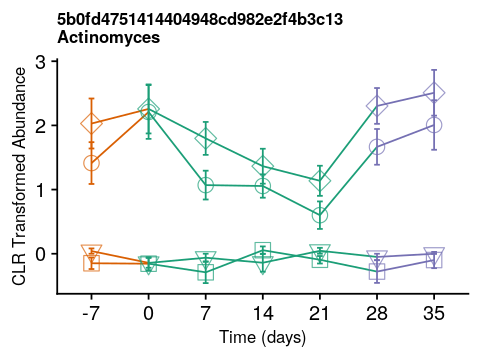

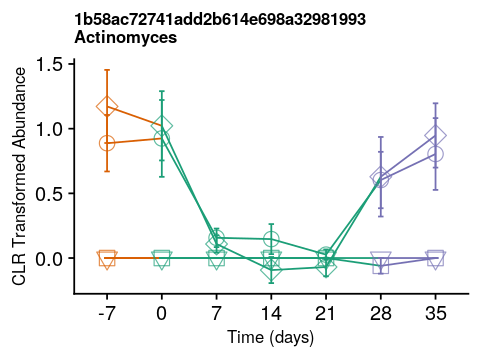

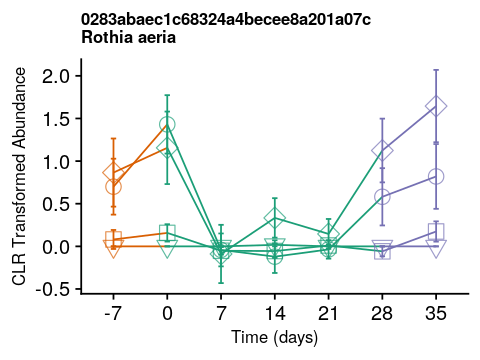

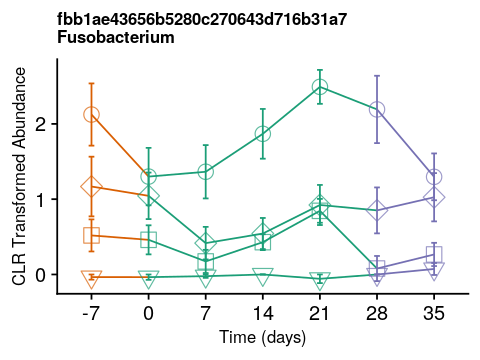

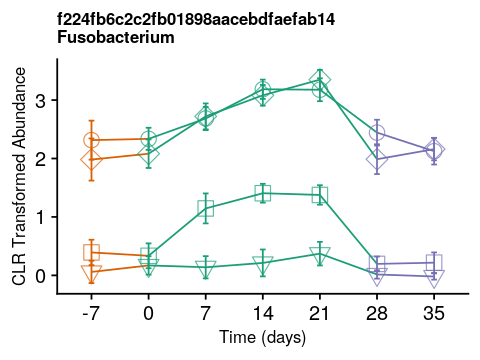

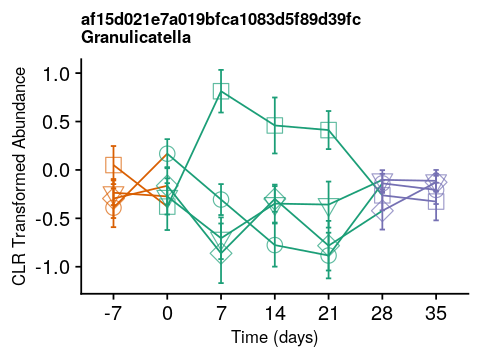

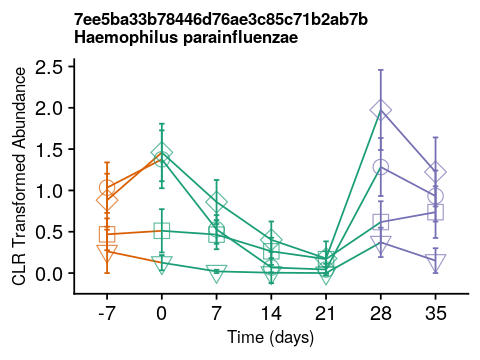

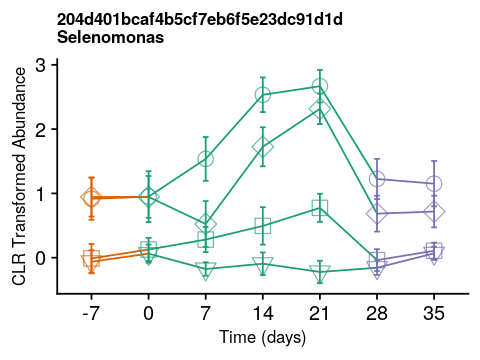

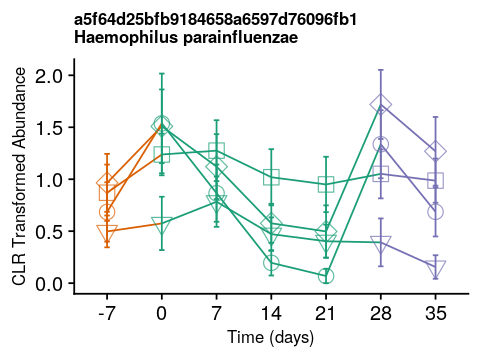

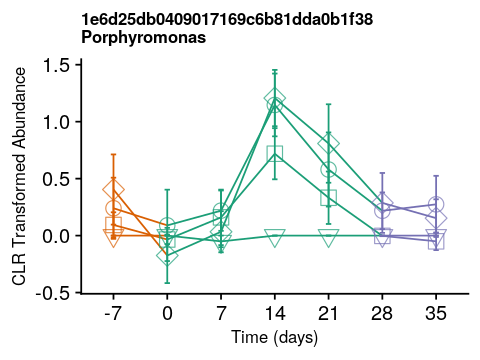

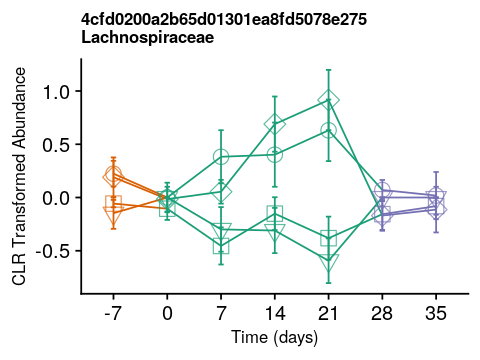

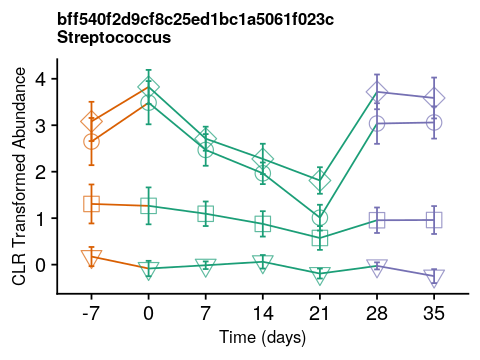

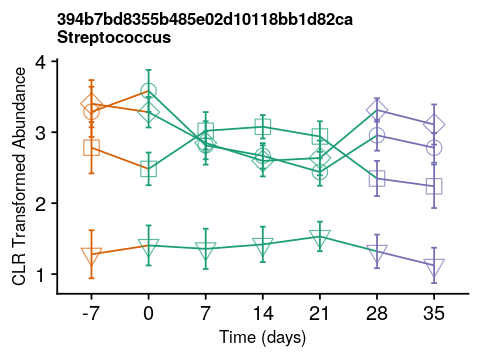

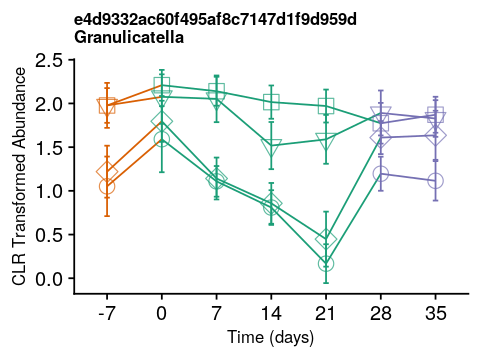

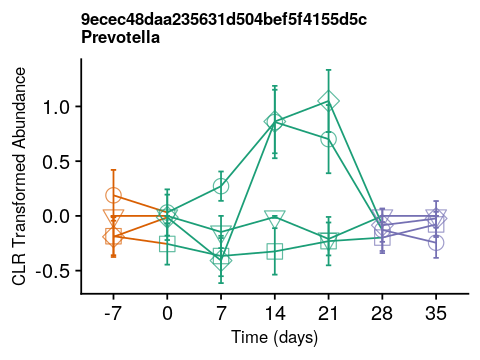

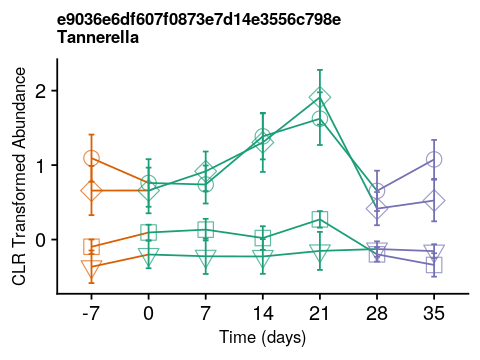

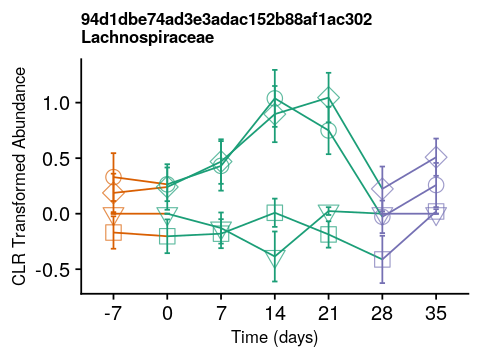

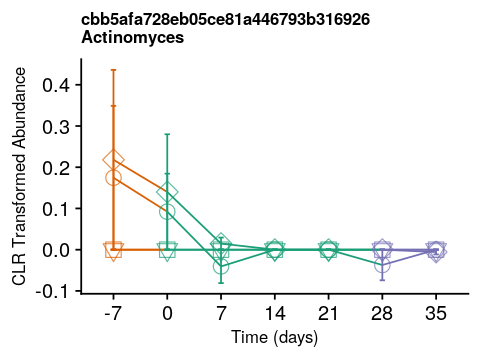

In [17]:
options(repr.plot.width=4, repr.plot.height=3)
#pdf("significant_ASV_timeseries.pdf", width=4, height=3)
plot_sig_time_series("5b0fd4751414404948cd982e2f4b3c13")
plot_sig_time_series("1b58ac72741add2b614e698a32981993")
plot_sig_time_series("0283abaec1c68324a4becee8a201a07c")
plot_sig_time_series("fbb1ae43656b5280c270643d716b31a7")
plot_sig_time_series("f224fb6c2c2fb01898aacebdfaefab14")
plot_sig_time_series("af15d021e7a019bfca1083d5f89d39fc")
plot_sig_time_series("7ee5ba33b78446d76ae3c85c71b2ab7b")
plot_sig_time_series("204d401bcaf4b5cf7eb6f5e23dc91d1d")
plot_sig_time_series("a5f64d25bfb9184658a6597d76096fb1")
plot_sig_time_series("1e6d25db0409017169c6b81dda0b1f38")
plot_sig_time_series("4cfd0200a2b65d01301ea8fd5078e275")
plot_sig_time_series("bff540f2d9cf8c25ed1bc1a5061f023c")
plot_sig_time_series("394b7bd8355b485e02d10118bb1d82ca")
plot_sig_time_series("e4d9332ac60f495af8c7147d1f9d959d")
plot_sig_time_series("9ecec48daa235631d504bef5f4155d5c")
plot_sig_time_series("e9036e6df607f0873e7d14e3556c798e")
plot_sig_time_series("94d1dbe74ad3e3adac152b88af1ac302")
plot_sig_time_series("cbb5afa728eb05ce81a446793b316926")
#plot_aggregated_time_series(c("a6b2fa"))
#sum(asv_tab["ff1a500ee3d4707ab84f98d8b",])
#sum(asv_tab["a6b2fa563ccfa81a930164712bf75312",])
#plot_aggregated_time_series(c("ff1a500ee3d4707ab84f98d8b","a6b2fa563ccfa81930164712bf75312"))
#plot_aggregated_time_series(c("752489758b89edd9ab389e9af3a85525", 
#                                    "5320c8a5037af1f07c018918f199ac1b", 
#                                    "6711750272cc5532a81283651f7c1683", 
#                                    "58780a2f2d5da67505b38276ad66bf10"))
#plot_aggregated_time_series(c("5cfbb66de42f198073e88fa77685b4fe",
#                             "9575b865a600496974e62a2c38da3ce2"))
#plot_sig_time_series("5cfbb66de42f198073e88fa77685b4fe")
#plot_sig_time_series("9575b865a600496974e62a2c38da3ce2")
#dev.off()

In [45]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2      stringr_1.3.1       gridExtra_2.3      
 [4] lmerTest_3.0-1      lme4_1.1-18-1       Matrix_1.2-8       
 [7] reshape2_1.4.3      cowplot_0.9.3       ggplot2_3.1.0      
[10] compositions_1.40-2 bayesm_3.1-0.1      energy_1.7-5       
[13] robus